In [140]:
# === Importer ===
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow och Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2 # pyright: ignore[reportMissingImports]
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn-verktyg
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils import class_weight


In [141]:
# === Reproducerbarhet ===
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(train_generator.class_indices)


{'no': 0, 'yes': 1}


In [142]:
# === Datageneratorer ===
base_dir = "brain_tumor_dataset"
img_size = 160
bs = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
    zoom_range=0.5,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=seed
)

x_batch, y_batch = next(val_generator)
print("Shape på batch:", x_batch.shape)
print("Exempel på y_batch:", y_batch[:10])
print("Unika etiketter i batch:", np.unique(y_batch))

print("class_indices:", train_generator.class_indices)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Shape på batch: (32, 160, 160, 3)
Exempel på y_batch: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Unika etiketter i batch: [0. 1.]
class_indices: {'no': 0, 'yes': 1}


In [143]:
# === Klassvikter ===
classes = train_generator.classes
unique, counts = np.unique(classes, return_counts=True)
print("train counts:", dict(zip(unique, counts)))

class_weights = None
if len(unique) == 2:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=unique,
        y=classes
    )
    class_weights = {int(k): float(v) for k, v in zip(unique, weights)}
    print("class_weights:", class_weights)



train counts: {0: 79, 1: 124}
class_weights: {0: 1.2848101265822784, 1: 0.8185483870967742}


In [144]:
# === Modell ===
base = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=out)

imgs, _ = next(train_generator)
print("Min:", imgs.min(), "Max:", imgs.max(), "Medel:", imgs.mean())

Min: -1.0 Max: 1.0 Medel: -0.5374915


In [145]:
# === Finjustering ===
base.trainable = True  # lås upp hela basen, men vi fryser de första lagren nedan
for layer in base.layers[:50]:  # fryser första 70 av ~155 lager
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.backend.clear_session()
    ]
)

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early, reduce],
    verbose=1
)

c:\Users\olive\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.4729 - auc: 0.5883 - loss: 0.8211 - precision: 0.6441 - recall: 0.3065 - val_accuracy: 0.4000 - val_auc: 0.4516 - val_loss: 1.1919 - val_precision: 0.6000 - val_recall: 0.0968 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.6010 - auc: 0.7131 - loss: 0.6596 - precision: 0.7945 - recall: 0.4677 - val_accuracy: 0.4400 - val_auc: 0.7504 - val_loss: 1.1266 - val_precision: 1.0000 - val_recall: 0.0968 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6878 - auc: 0.8359 - loss: 0.5374 - precision: 0.8682 - recall: 0.5834
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.6995 - auc: 0.8189 - loss: 0.5416 - precision: 0.8539 - recall: 0.6129 - val_accuracy: 0.4600 - val_auc: 0.8540 - val_loss: 1.1605 - val_precision: 1.0000 - val_recall: 0.1290 - learning_rate: 1.0000

Bästa tröskel enligt F1: 0.10
              precision    recall  f1-score   support

          no       0.46      0.84      0.59        19
         yes       0.80      0.39      0.52        31

    accuracy                           0.56        50
   macro avg       0.63      0.61      0.56        50
weighted avg       0.67      0.56      0.55        50

[[16  3]
 [19 12]]

Tröskel: 0.15
[[ 9 10]
 [ 9 22]]
              precision    recall  f1-score   support

          no       0.50      0.47      0.49        19
         yes       0.69      0.71      0.70        31

    accuracy                           0.62        50
   macro avg       0.59      0.59      0.59        50
weighted avg       0.62      0.62      0.62        50


Tröskel: 0.2
[[10  9]
 [12 19]]
              precision    recall  f1-score   support

          no       0.45      0.53      0.49        19
         yes       0.68      0.61      0.64        31

    accuracy                           0.58        50
   macro avg

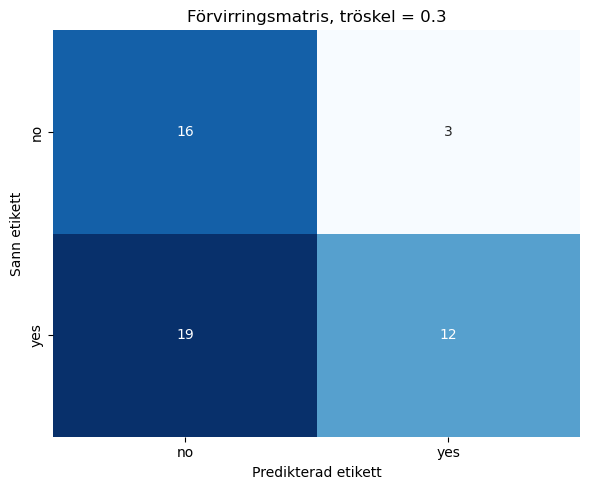

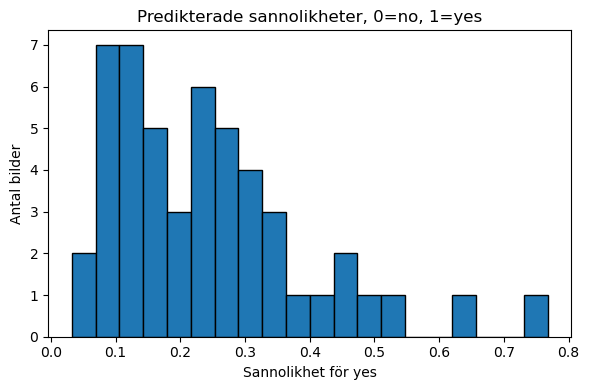

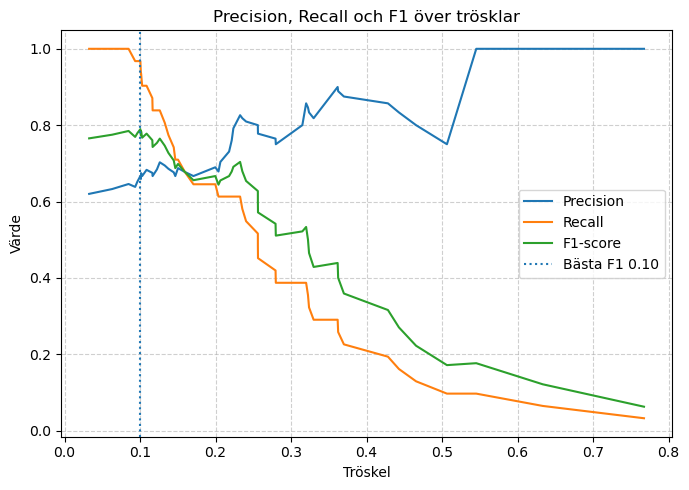

In [146]:
# === Utvärdering ===

# 1. Prediktioner och sanningsdata
val_generator.reset()
probs = model.predict(val_generator, verbose=0).ravel()
y_true = val_generator.classes

# 2. Precision, recall och F1 per tröskel
prec, rec, thr = precision_recall_curve(y_true, probs)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.nanargmax(f1)
best_thr = 0.5 if best_idx >= len(thr) else float(thr[best_idx])
print(f"Bästa tröskel enligt F1: {best_thr:.2f}")

# 3. Utvärdering vid vald tröskel
threshold = 0.30   # ändra fritt
y_pred = (probs >= threshold).astype(int)
print(classification_report(y_true, y_pred, target_names=['no', 'yes']))
print(confusion_matrix(y_true, y_pred))

# 4. Snabb sweep över några trösklar
for t in [0.15, 0.20, 0.25, 0.30, 0.35]:
    yp = (probs >= t).astype(int)
    print(f"\nTröskel: {t}")
    print(confusion_matrix(y_true, yp))
    print(classification_report(y_true, yp, target_names=['no','yes']))

# 5. Plot: förvirringsmatris
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predikterad etikett')
plt.ylabel('Sann etikett')
plt.title(f'Förvirringsmatris, tröskel = {threshold}')
plt.tight_layout()
plt.show()

# 6. Plot: sannolikhetsfördelning
plt.figure(figsize=(6, 4))
plt.hist(probs, bins=20, edgecolor='black')
plt.title("Predikterade sannolikheter, 0=no, 1=yes")
plt.xlabel("Sannolikhet för yes")
plt.ylabel("Antal bilder")
plt.tight_layout()
plt.show()

# 7. Plot: Precision, Recall och F1 över trösklar
plt.figure(figsize=(7, 5))
plt.plot(thr, prec[:-1], label='Precision')
plt.plot(thr, rec[:-1], label='Recall')
plt.plot(thr, f1[:-1], label='F1-score')
plt.axvline(x=best_thr, linestyle=':', label=f'Bästa F1 {best_thr:.2f}')
plt.xlabel("Tröskel")
plt.ylabel("Värde")
plt.title("Precision, Recall och F1 över trösklar")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
